# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [4]:
# GLOBALS
# -----------------------

# data_dir = 'data/cifar10'
data_dir = 'data/hiragana'
batch_size = 128


## Data augmentation: Training set

0it [00:00, ?it/s]

100%|█████████▉| 170115072/170498071 [00:48<00:00, 5058041.40it/s]

Files already downloaded and verified


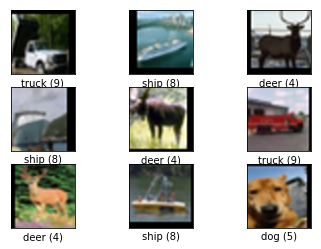

torch.Size([128, 3, 32, 32])


In [5]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

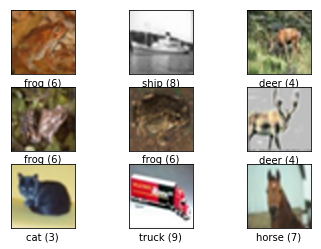

torch.Size([128, 3, 32, 32])


In [6]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

**There** are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [7]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

170500096it [00:59, 5058041.40it/s]                               

Files already downloaded and verified
Files already downloaded and verified
means: [0.4918687901200918, 0.49187385748544105, 0.49185755343050747]
stds: [0.24697121702736027, 0.24696501584536895, 0.24696575435989954]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [8]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [9]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [10]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [11]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = torch.nn.DataParallel(ResNet(n, shortcuts=False)) # modified from original
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.074
1 	100 	1.870
1 	150 	1.810
1 	200 	1.749
1 	250 	1.705
1 	300 	1.672
1 	350 	1.622
train_err: 0.60518 test_err: 0.593
2 	50 	1.555
2 	100 	1.521
2 	150 	1.514
2 	200 	1.435
2 	250 	1.368
2 	300 	1.338
2 	350 	1.294
train_err: 0.4947 test_err: 0.4795
3 	50 	1.217
3 	100 	1.203
3 	150 	1.146
3 	200 	1.144
3 	250 	1.101
3 	300 	1.042
3 	350 	1.015
train_err: 0.40744 test_err: 0.41
4 	50 	0.978
4 	100 	0.956
4 	150 	0.946
4 	200 	0.943
4 	250 	0.879
4 	300 	0.902
4 	350 	0.910
train_err: 0.3449 test_err: 0.3375
5 	50 	0.837
5 	100 	0.827
5 	150 	0.814
5 	200 	0.820
5 	250 	0.783
5 	300 	0.829
5 	350 	0.800
train_err: 0.28536 test_err: 0.2791
6 	50 	0.746
6 	100 	0.754
6 	150 	0.737
6 	200 	0.760
6 	250 	0.744
6 	300 	0.728
6 	350 	0.708
train_err: 0.26932 test_err: 0.2782
7 	50 	0.691
7 	100 	0.704
7 	150 	0.668
7 	200 	0.677
7 	250 	0.680
7 	300 	0.6

59 	200 	0.310
59 	250 	0.301
59 	300 	0.323
59 	350 	0.338
train_err: 0.14498 test_err: 0.1892
60 	50 	0.296
60 	100 	0.303
60 	150 	0.315
60 	200 	0.320
60 	250 	0.311
60 	300 	0.308
60 	350 	0.313
train_err: 0.13704 test_err: 0.1649
61 	50 	0.291
61 	100 	0.289
61 	150 	0.315
61 	200 	0.313
61 	250 	0.300
61 	300 	0.308
61 	350 	0.328
train_err: 0.11604 test_err: 0.1488
62 	50 	0.318
62 	100 	0.314
62 	150 	0.312
62 	200 	0.297
62 	250 	0.302
62 	300 	0.317
62 	350 	0.309
train_err: 0.1175 test_err: 0.1511
63 	50 	0.294
63 	100 	0.303
63 	150 	0.305
63 	200 	0.323
63 	250 	0.306
63 	300 	0.314
63 	350 	0.320
train_err: 0.11214 test_err: 0.1452
64 	50 	0.319
64 	100 	0.290
64 	150 	0.310
64 	200 	0.313
64 	250 	0.301
64 	300 	0.307
64 	350 	0.294
train_err: 0.1305 test_err: 0.1693
65 	50 	0.289
65 	100 	0.298
65 	150 	0.315
65 	200 	0.293
65 	250 	0.332
65 	300 	0.301
65 	350 	0.329
train_err: 0.12454 test_err: 0.1593
66 	50 	0.284
66 	100 	0.281
66 	150 	0.311
66 	200 	0.287
66 	250

117 	150 	0.070
117 	200 	0.066
117 	250 	0.067
117 	300 	0.069
117 	350 	0.070
train_err: 0.01814 test_err: 0.0977
118 	50 	0.060
118 	100 	0.063
118 	150 	0.065
118 	200 	0.073
118 	250 	0.071
118 	300 	0.073
118 	350 	0.068
train_err: 0.0203 test_err: 0.0988
119 	50 	0.061
119 	100 	0.064
119 	150 	0.068
119 	200 	0.060
119 	250 	0.065
119 	300 	0.074
119 	350 	0.061
train_err: 0.01832 test_err: 0.1024
120 	50 	0.066
120 	100 	0.060
120 	150 	0.066
120 	200 	0.063
120 	250 	0.060
120 	300 	0.061
120 	350 	0.069
train_err: 0.01758 test_err: 0.1003
121 	50 	0.066
121 	100 	0.066
121 	150 	0.066
121 	200 	0.070
121 	250 	0.064
121 	300 	0.064
121 	350 	0.068
train_err: 0.01852 test_err: 0.0983
122 	50 	0.068
122 	100 	0.061
122 	150 	0.064
122 	200 	0.062
122 	250 	0.060
122 	300 	0.062
122 	350 	0.066
train_err: 0.01732 test_err: 0.1003
123 	50 	0.058
123 	100 	0.064
123 	150 	0.055
123 	200 	0.058
123 	250 	0.060
123 	300 	0.069
123 	350 	0.068
train_err: 0.01652 test_err: 0.0979
124

9 	50 	0.948
9 	100 	0.942
9 	150 	0.946
9 	200 	0.946
9 	250 	0.907
9 	300 	0.904
9 	350 	0.912
train_err: 0.3769 test_err: 0.3553
10 	50 	0.869
10 	100 	0.864
10 	150 	0.876
10 	200 	0.899
10 	250 	0.868
10 	300 	0.836
10 	350 	0.880
train_err: 0.30594 test_err: 0.3034
11 	50 	0.833
11 	100 	0.837
11 	150 	0.826
11 	200 	0.834
11 	250 	0.820
11 	300 	0.839
11 	350 	0.815
train_err: 0.3126 test_err: 0.3164
12 	50 	0.768
12 	100 	0.778
12 	150 	0.796
12 	200 	0.793
12 	250 	0.787
12 	300 	0.759
12 	350 	0.789
train_err: 0.30678 test_err: 0.3166
13 	50 	0.753
13 	100 	0.723
13 	150 	0.733
13 	200 	0.757
13 	250 	0.738
13 	300 	0.768
13 	350 	0.722
train_err: 0.27636 test_err: 0.2774
14 	50 	0.704
14 	100 	0.755
14 	150 	0.720
14 	200 	0.716
14 	250 	0.726
14 	300 	0.721
14 	350 	0.712
train_err: 0.2874 test_err: 0.2847
15 	50 	0.715
15 	100 	0.669
15 	150 	0.707
15 	200 	0.690
15 	250 	0.682
15 	300 	0.685
15 	350 	0.691
train_err: 0.26748 test_err: 0.2791
16 	50 	0.672
16 	100 	0.678
1

train_err: 0.18818 test_err: 0.2169
68 	50 	0.362
68 	100 	0.386
68 	150 	0.367
68 	200 	0.360
68 	250 	0.374
68 	300 	0.374
68 	350 	0.380
train_err: 0.15516 test_err: 0.1789
69 	50 	0.351
69 	100 	0.362
69 	150 	0.389
69 	200 	0.341
69 	250 	0.369
69 	300 	0.369
69 	350 	0.360
train_err: 0.14062 test_err: 0.1647
70 	50 	0.325
70 	100 	0.371
70 	150 	0.360
70 	200 	0.355
70 	250 	0.354
70 	300 	0.405
70 	350 	0.375
train_err: 0.1591 test_err: 0.1798
71 	50 	0.321
71 	100 	0.360
71 	150 	0.367
71 	200 	0.377
71 	250 	0.355
71 	300 	0.358
71 	350 	0.362
train_err: 0.1375 test_err: 0.1647
72 	50 	0.353
72 	100 	0.381
72 	150 	0.359
72 	200 	0.358
72 	250 	0.361
72 	300 	0.340
72 	350 	0.388
train_err: 0.1915 test_err: 0.2293
73 	50 	0.368
73 	100 	0.340
73 	150 	0.345
73 	200 	0.368
73 	250 	0.351
73 	300 	0.373
73 	350 	0.357
train_err: 0.1601 test_err: 0.1809
74 	50 	0.356
74 	100 	0.360
74 	150 	0.359
74 	200 	0.371
74 	250 	0.349
74 	300 	0.376
74 	350 	0.380
train_err: 0.12188 test_

125 	150 	0.071
125 	200 	0.064
125 	250 	0.064
125 	300 	0.063
125 	350 	0.064
train_err: 0.01588 test_err: 0.0959
126 	50 	0.058
126 	100 	0.057
126 	150 	0.055
126 	200 	0.060
126 	250 	0.061
126 	300 	0.057
126 	350 	0.051
train_err: 0.01486 test_err: 0.0947
127 	50 	0.056
127 	100 	0.057
127 	150 	0.060
127 	200 	0.055
127 	250 	0.059
127 	300 	0.062
127 	350 	0.056
train_err: 0.01406 test_err: 0.0941
128 	50 	0.058
128 	100 	0.051
128 	150 	0.058
128 	200 	0.054
128 	250 	0.055
128 	300 	0.056
128 	350 	0.053
train_err: 0.0139 test_err: 0.0925
129 	50 	0.046
129 	100 	0.048
129 	150 	0.055
129 	200 	0.051
129 	250 	0.045
129 	300 	0.055
129 	350 	0.047
train_err: 0.01338 test_err: 0.0931
130 	50 	0.052
130 	100 	0.044
130 	150 	0.051
130 	200 	0.054
130 	250 	0.054
130 	300 	0.054
130 	350 	0.052
train_err: 0.01322 test_err: 0.0933
131 	50 	0.047
131 	100 	0.054
131 	150 	0.045
131 	200 	0.051
131 	250 	0.056
131 	300 	0.053
131 	350 	0.049
train_err: 0.01308 test_err: 0.093
132 

17 	200 	0.945
17 	250 	0.903
17 	300 	0.956
17 	350 	0.922
train_err: 0.37666 test_err: 0.3632
18 	50 	0.899
18 	100 	0.941
18 	150 	0.931
18 	200 	0.902
18 	250 	0.900
18 	300 	0.900
18 	350 	0.873
train_err: 0.3607 test_err: 0.3619
19 	50 	0.893
19 	100 	0.866
19 	150 	0.840
19 	200 	0.876
19 	250 	0.861
19 	300 	0.895
19 	350 	0.864
train_err: 0.40144 test_err: 0.3967
20 	50 	0.805
20 	100 	0.864
20 	150 	0.856
20 	200 	0.830
20 	250 	0.862
20 	300 	0.834
20 	350 	0.850
train_err: 0.3231 test_err: 0.3225
21 	50 	0.833
21 	100 	0.850
21 	150 	0.819
21 	200 	0.851
21 	250 	0.808
21 	300 	0.828
21 	350 	0.842
train_err: 0.355 test_err: 0.352
22 	50 	0.810
22 	100 	0.790
22 	150 	0.823
22 	200 	0.815
22 	250 	0.816
22 	300 	0.792
22 	350 	0.801
train_err: 0.39652 test_err: 0.3976
23 	50 	0.774
23 	100 	0.794
23 	150 	0.807
23 	200 	0.789
23 	250 	0.776
23 	300 	0.792
23 	350 	0.789
train_err: 0.33382 test_err: 0.3535
24 	50 	0.761
24 	100 	0.764
24 	150 	0.757
24 	200 	0.759
24 	250 	0

76 	50 	0.467
76 	100 	0.465
76 	150 	0.464
76 	200 	0.472
76 	250 	0.467
76 	300 	0.501
76 	350 	0.480
train_err: 0.2109 test_err: 0.236
77 	50 	0.470
77 	100 	0.473
77 	150 	0.446
77 	200 	0.487
77 	250 	0.479
77 	300 	0.487
77 	350 	0.473
train_err: 0.23354 test_err: 0.2322
78 	50 	0.467
78 	100 	0.466
78 	150 	0.474
78 	200 	0.470
78 	250 	0.481
78 	300 	0.486
78 	350 	0.487
train_err: 0.18482 test_err: 0.2069
79 	50 	0.460
79 	100 	0.456
79 	150 	0.470
79 	200 	0.474
79 	250 	0.468
79 	300 	0.462
79 	350 	0.490
train_err: 0.32846 test_err: 0.3321
80 	50 	0.465
80 	100 	0.459
80 	150 	0.482
80 	200 	0.454
80 	250 	0.472
80 	300 	0.491
80 	350 	0.462
train_err: 0.20034 test_err: 0.2149
81 	50 	0.447
81 	100 	0.453
81 	150 	0.503
81 	200 	0.464
81 	250 	0.467
81 	300 	0.456
81 	350 	0.463
train_err: 0.19138 test_err: 0.2037
82 	50 	0.471
82 	100 	0.467
82 	150 	0.459
82 	200 	0.463
82 	250 	0.458
82 	300 	0.491
82 	350 	0.477
train_err: 0.22476 test_err: 0.2375
83 	50 	0.445
83 	100 

133 	100 	0.106
133 	150 	0.114
133 	200 	0.127
133 	250 	0.124
133 	300 	0.113
133 	350 	0.112
train_err: 0.03384 test_err: 0.1159
134 	50 	0.113
134 	100 	0.115
134 	150 	0.117
134 	200 	0.109
134 	250 	0.114
134 	300 	0.117
134 	350 	0.117
train_err: 0.03382 test_err: 0.117
135 	50 	0.111
135 	100 	0.120
135 	150 	0.114
135 	200 	0.107
135 	250 	0.114
135 	300 	0.111
135 	350 	0.119
train_err: 0.03306 test_err: 0.1152
136 	50 	0.106
136 	100 	0.111
136 	150 	0.110
136 	200 	0.122
136 	250 	0.113
136 	300 	0.108
136 	350 	0.119
train_err: 0.03184 test_err: 0.1156
137 	50 	0.117
137 	100 	0.112
137 	150 	0.105
137 	200 	0.105
137 	250 	0.112
137 	300 	0.118
137 	350 	0.112
train_err: 0.0325 test_err: 0.1163
138 	50 	0.115
138 	100 	0.111
138 	150 	0.120
138 	200 	0.105
138 	250 	0.110
138 	300 	0.111
138 	350 	0.126
train_err: 0.03126 test_err: 0.1172
139 	50 	0.110
139 	100 	0.100
139 	150 	0.100
139 	200 	0.111
139 	250 	0.123
139 	300 	0.121
139 	350 	0.113
train_err: 0.03364 test_

25 	350 	1.310
train_err: 0.47804 test_err: 0.4646
26 	50 	1.313
26 	100 	1.266
26 	150 	1.284
26 	200 	1.264
26 	250 	1.268
26 	300 	1.296
26 	350 	1.283
train_err: 0.49778 test_err: 0.488
27 	50 	1.273
27 	100 	1.261
27 	150 	1.259
27 	200 	1.231
27 	250 	1.271
27 	300 	1.243
27 	350 	1.215
train_err: 0.46564 test_err: 0.4541
28 	50 	1.200
28 	100 	1.184
28 	150 	1.202
28 	200 	1.209
28 	250 	1.202
28 	300 	1.195
28 	350 	1.206
train_err: 0.47662 test_err: 0.4639
29 	50 	1.199
29 	100 	1.185
29 	150 	1.213
29 	200 	1.164
29 	250 	1.185
29 	300 	1.162
29 	350 	1.178
train_err: 0.46402 test_err: 0.4458
30 	50 	1.151
30 	100 	1.161
30 	150 	1.167
30 	200 	1.155
30 	250 	1.149
30 	300 	1.142
30 	350 	1.151
train_err: 0.50464 test_err: 0.4777
31 	50 	1.143
31 	100 	1.132
31 	150 	1.152
31 	200 	1.125
31 	250 	1.085
31 	300 	1.127
31 	350 	1.118
train_err: 0.5024 test_err: 0.4836
32 	50 	1.124
32 	100 	1.080
32 	150 	1.093
32 	200 	1.079
32 	250 	1.106
32 	300 	1.087
32 	350 	1.091
train_e

84 	200 	0.441
84 	250 	0.440
84 	300 	0.460
84 	350 	0.452
train_err: 0.14264 test_err: 0.1662
85 	50 	0.428
85 	100 	0.422
85 	150 	0.418
85 	200 	0.426
85 	250 	0.420
85 	300 	0.429
85 	350 	0.421
train_err: 0.13762 test_err: 0.1635
86 	50 	0.416
86 	100 	0.418
86 	150 	0.425
86 	200 	0.404
86 	250 	0.410
86 	300 	0.414
86 	350 	0.405
train_err: 0.13492 test_err: 0.1624
87 	50 	0.397
87 	100 	0.404
87 	150 	0.408
87 	200 	0.404
87 	250 	0.400
87 	300 	0.402
87 	350 	0.380
train_err: 0.13264 test_err: 0.1605
88 	50 	0.391
88 	100 	0.405
88 	150 	0.399
88 	200 	0.393
88 	250 	0.397
88 	300 	0.393
88 	350 	0.392
train_err: 0.12904 test_err: 0.1588
89 	50 	0.371
89 	100 	0.375
89 	150 	0.403
89 	200 	0.385
89 	250 	0.413
89 	300 	0.397
89 	350 	0.394
train_err: 0.1291 test_err: 0.1614
90 	50 	0.376
90 	100 	0.383
90 	150 	0.391
90 	200 	0.383
90 	250 	0.382
90 	300 	0.378
90 	350 	0.385
train_err: 0.12618 test_err: 0.1571
91 	50 	0.391
91 	100 	0.380
91 	150 	0.363
91 	200 	0.383
91 	25

141 	50 	0.255
141 	100 	0.244
141 	150 	0.257
141 	200 	0.240
141 	250 	0.245
141 	300 	0.260
141 	350 	0.251
train_err: 0.0809 test_err: 0.14
142 	50 	0.247
142 	100 	0.257
142 	150 	0.247
142 	200 	0.243
142 	250 	0.261
142 	300 	0.228
142 	350 	0.257
train_err: 0.07866 test_err: 0.1397
143 	50 	0.249
143 	100 	0.250
143 	150 	0.251
143 	200 	0.252
143 	250 	0.227
143 	300 	0.261
143 	350 	0.258
train_err: 0.07908 test_err: 0.1407
144 	50 	0.259
144 	100 	0.243
144 	150 	0.242
144 	200 	0.260
144 	250 	0.257
144 	300 	0.238
144 	350 	0.251
train_err: 0.07974 test_err: 0.1412
145 	50 	0.235
145 	100 	0.266
145 	150 	0.243
145 	200 	0.251
145 	250 	0.245
145 	300 	0.238
145 	350 	0.249
train_err: 0.08046 test_err: 0.1417
146 	50 	0.249
146 	100 	0.243
146 	150 	0.258
146 	200 	0.254
146 	250 	0.236
146 	300 	0.236
146 	350 	0.241
train_err: 0.07874 test_err: 0.1416
147 	50 	0.266
147 	100 	0.236
147 	150 	0.237
147 	200 	0.249
147 	250 	0.255
147 	300 	0.233
147 	350 	0.254
train_err:

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [12]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = torch.nn.DataParallel(ResNet(n, shortcuts=True)) # modified from original
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.341
1 	100 	1.890
1 	150 	1.785
1 	200 	1.701
1 	250 	1.642
1 	300 	1.573
1 	350 	1.524
train_err: 0.54748 test_err: 0.5449
2 	50 	1.404
2 	100 	1.336
2 	150 	1.290
2 	200 	1.269
2 	250 	1.189
2 	300 	1.165
2 	350 	1.154
train_err: 0.45666 test_err: 0.4688
3 	50 	1.063
3 	100 	1.013
3 	150 	1.018
3 	200 	0.967
3 	250 	0.970
3 	300 	0.924
3 	350 	0.864
train_err: 0.33278 test_err: 0.3271
4 	50 	0.845
4 	100 	0.862
4 	150 	0.820
4 	200 	0.800
4 	250 	0.775
4 	300 	0.775
4 	350 	0.737
train_err: 0.29706 test_err: 0.298
5 	50 	0.709
5 	100 	0.692
5 	150 	0.685
5 	200 	0.692
5 	250 	0.684
5 	300 	0.681
5 	350 	0.677
train_err: 0.25996 test_err: 0.2737
6 	50 	0.614
6 	100 	0.638
6 	150 	0.622
6 	200 	0.618
6 	250 	0.619
6 	300 	0.619
6 	350 	0.602
train_err: 0.25598 test_err: 0.2708
7 	50 	0.581
7 	100 	0.566
7 	150 	0.586
7 	200 	0.582
7 	250 	0.569
7 	300 

59 	150 	0.254
59 	200 	0.256
59 	250 	0.248
59 	300 	0.235
59 	350 	0.235
train_err: 0.09542 test_err: 0.1396
60 	50 	0.223
60 	100 	0.241
60 	150 	0.240
60 	200 	0.259
60 	250 	0.253
60 	300 	0.263
60 	350 	0.250
train_err: 0.10726 test_err: 0.1479
61 	50 	0.235
61 	100 	0.221
61 	150 	0.239
61 	200 	0.264
61 	250 	0.230
61 	300 	0.249
61 	350 	0.263
train_err: 0.09328 test_err: 0.1399
62 	50 	0.232
62 	100 	0.236
62 	150 	0.240
62 	200 	0.226
62 	250 	0.270
62 	300 	0.256
62 	350 	0.245
train_err: 0.0882 test_err: 0.1339
63 	50 	0.217
63 	100 	0.233
63 	150 	0.229
63 	200 	0.249
63 	250 	0.257
63 	300 	0.246
63 	350 	0.250
train_err: 0.10994 test_err: 0.1586
64 	50 	0.226
64 	100 	0.231
64 	150 	0.245
64 	200 	0.238
64 	250 	0.248
64 	300 	0.236
64 	350 	0.245
train_err: 0.12478 test_err: 0.1685
65 	50 	0.238
65 	100 	0.228
65 	150 	0.247
65 	200 	0.264
65 	250 	0.258
65 	300 	0.248
65 	350 	0.241
train_err: 0.13214 test_err: 0.1795
66 	50 	0.219
66 	100 	0.225
66 	150 	0.239
66 	20

117 	50 	0.042
117 	100 	0.049
117 	150 	0.046
117 	200 	0.040
117 	250 	0.044
117 	300 	0.043
117 	350 	0.044
train_err: 0.01076 test_err: 0.0876
118 	50 	0.038
118 	100 	0.042
118 	150 	0.041
118 	200 	0.038
118 	250 	0.044
118 	300 	0.047
118 	350 	0.042
train_err: 0.0105 test_err: 0.0859
119 	50 	0.040
119 	100 	0.037
119 	150 	0.050
119 	200 	0.041
119 	250 	0.042
119 	300 	0.046
119 	350 	0.039
train_err: 0.01026 test_err: 0.0892
120 	50 	0.038
120 	100 	0.038
120 	150 	0.045
120 	200 	0.038
120 	250 	0.043
120 	300 	0.042
120 	350 	0.044
train_err: 0.00946 test_err: 0.0886
121 	50 	0.039
121 	100 	0.042
121 	150 	0.039
121 	200 	0.042
121 	250 	0.035
121 	300 	0.038
121 	350 	0.042
train_err: 0.00902 test_err: 0.0851
122 	50 	0.034
122 	100 	0.035
122 	150 	0.034
122 	200 	0.036
122 	250 	0.038
122 	300 	0.043
122 	350 	0.039
train_err: 0.0081 test_err: 0.0883
123 	50 	0.035
123 	100 	0.039
123 	150 	0.038
123 	200 	0.037
123 	250 	0.042
123 	300 	0.041
123 	350 	0.046
train_err

8 	350 	0.617
train_err: 0.2247 test_err: 0.2402
9 	50 	0.586
9 	100 	0.589
9 	150 	0.604
9 	200 	0.603
9 	250 	0.596
9 	300 	0.571
9 	350 	0.564
train_err: 0.22928 test_err: 0.2441
10 	50 	0.535
10 	100 	0.551
10 	150 	0.553
10 	200 	0.535
10 	250 	0.566
10 	300 	0.542
10 	350 	0.518
train_err: 0.24394 test_err: 0.2763
11 	50 	0.509
11 	100 	0.503
11 	150 	0.513
11 	200 	0.498
11 	250 	0.527
11 	300 	0.518
11 	350 	0.528
train_err: 0.16604 test_err: 0.1904
12 	50 	0.462
12 	100 	0.481
12 	150 	0.511
12 	200 	0.481
12 	250 	0.479
12 	300 	0.493
12 	350 	0.456
train_err: 0.1977 test_err: 0.2214
13 	50 	0.463
13 	100 	0.462
13 	150 	0.464
13 	200 	0.504
13 	250 	0.473
13 	300 	0.466
13 	350 	0.473
train_err: 0.1594 test_err: 0.178
14 	50 	0.424
14 	100 	0.437
14 	150 	0.450
14 	200 	0.449
14 	250 	0.446
14 	300 	0.430
14 	350 	0.445
train_err: 0.15194 test_err: 0.1741
15 	50 	0.418
15 	100 	0.424
15 	150 	0.407
15 	200 	0.448
15 	250 	0.449
15 	300 	0.452
15 	350 	0.432
train_err: 0.1518

67 	250 	0.210
67 	300 	0.234
67 	350 	0.228
train_err: 0.10684 test_err: 0.1522
68 	50 	0.206
68 	100 	0.203
68 	150 	0.203
68 	200 	0.195
68 	250 	0.223
68 	300 	0.230
68 	350 	0.249
train_err: 0.07706 test_err: 0.1259
69 	50 	0.190
69 	100 	0.206
69 	150 	0.212
69 	200 	0.225
69 	250 	0.207
69 	300 	0.220
69 	350 	0.221
train_err: 0.07746 test_err: 0.1296
70 	50 	0.187
70 	100 	0.210
70 	150 	0.225
70 	200 	0.207
70 	250 	0.214
70 	300 	0.232
70 	350 	0.237
train_err: 0.08264 test_err: 0.1334
71 	50 	0.204
71 	100 	0.202
71 	150 	0.210
71 	200 	0.211
71 	250 	0.224
71 	300 	0.208
71 	350 	0.216
train_err: 0.1053 test_err: 0.1606
72 	50 	0.194
72 	100 	0.199
72 	150 	0.205
72 	200 	0.226
72 	250 	0.221
72 	300 	0.206
72 	350 	0.216
train_err: 0.08492 test_err: 0.1318
73 	50 	0.197
73 	100 	0.206
73 	150 	0.208
73 	200 	0.218
73 	250 	0.240
73 	300 	0.229
73 	350 	0.226
train_err: 0.07738 test_err: 0.1215
74 	50 	0.186
74 	100 	0.200
74 	150 	0.204
74 	200 	0.211
74 	250 	0.220
74 	30

125 	50 	0.020
125 	100 	0.018
125 	150 	0.016
125 	200 	0.016
125 	250 	0.015
125 	300 	0.015
125 	350 	0.017
train_err: 0.00278 test_err: 0.0813
126 	50 	0.018
126 	100 	0.015
126 	150 	0.016
126 	200 	0.015
126 	250 	0.014
126 	300 	0.015
126 	350 	0.015
train_err: 0.00206 test_err: 0.0792
127 	50 	0.013
127 	100 	0.013
127 	150 	0.015
127 	200 	0.016
127 	250 	0.015
127 	300 	0.015
127 	350 	0.017
train_err: 0.0022 test_err: 0.0794
128 	50 	0.016
128 	100 	0.015
128 	150 	0.015
128 	200 	0.017
128 	250 	0.014
128 	300 	0.015
128 	350 	0.017
train_err: 0.00212 test_err: 0.0794
129 	50 	0.013
129 	100 	0.013
129 	150 	0.014
129 	200 	0.017
129 	250 	0.013
129 	300 	0.015
129 	350 	0.014
train_err: 0.0022 test_err: 0.0794
130 	50 	0.012
130 	100 	0.014
130 	150 	0.014
130 	200 	0.013
130 	250 	0.014
130 	300 	0.014
130 	350 	0.018
train_err: 0.0021 test_err: 0.0793
131 	50 	0.015
131 	100 	0.013
131 	150 	0.012
131 	200 	0.011
131 	250 	0.014
131 	300 	0.012
131 	350 	0.015
train_err:

17 	100 	0.405
17 	150 	0.441
17 	200 	0.435
17 	250 	0.429
17 	300 	0.412
17 	350 	0.437
train_err: 0.20672 test_err: 0.235
18 	50 	0.407
18 	100 	0.410
18 	150 	0.401
18 	200 	0.414
18 	250 	0.415
18 	300 	0.407
18 	350 	0.408
train_err: 0.17798 test_err: 0.2047
19 	50 	0.374
19 	100 	0.413
19 	150 	0.398
19 	200 	0.385
19 	250 	0.383
19 	300 	0.388
19 	350 	0.404
train_err: 0.13536 test_err: 0.1617
20 	50 	0.374
20 	100 	0.404
20 	150 	0.392
20 	200 	0.384
20 	250 	0.386
20 	300 	0.391
20 	350 	0.404
train_err: 0.1728 test_err: 0.2013
21 	50 	0.380
21 	100 	0.365
21 	150 	0.380
21 	200 	0.370
21 	250 	0.386
21 	300 	0.405
21 	350 	0.385
train_err: 0.15214 test_err: 0.1748
22 	50 	0.367
22 	100 	0.365
22 	150 	0.356
22 	200 	0.381
22 	250 	0.367
22 	300 	0.390
22 	350 	0.370
train_err: 0.1225 test_err: 0.1519
23 	50 	0.323
23 	100 	0.353
23 	150 	0.367
23 	200 	0.341
23 	250 	0.371
23 	300 	0.378
23 	350 	0.383
train_err: 0.16852 test_err: 0.1981
24 	50 	0.336
24 	100 	0.344
24 	150 

76 	50 	0.192
76 	100 	0.181
76 	150 	0.204
76 	200 	0.229
76 	250 	0.229
76 	300 	0.204
76 	350 	0.206
train_err: 0.0759 test_err: 0.1256
77 	50 	0.184
77 	100 	0.217
77 	150 	0.203
77 	200 	0.199
77 	250 	0.204
77 	300 	0.196
77 	350 	0.189
train_err: 0.0754 test_err: 0.129
78 	50 	0.192
78 	100 	0.177
78 	150 	0.212
78 	200 	0.187
78 	250 	0.191
78 	300 	0.210
78 	350 	0.215
train_err: 0.09062 test_err: 0.136
79 	50 	0.211
79 	100 	0.181
79 	150 	0.205
79 	200 	0.187
79 	250 	0.194
79 	300 	0.205
79 	350 	0.191
train_err: 0.07866 test_err: 0.1302
80 	50 	0.192
80 	100 	0.185
80 	150 	0.189
80 	200 	0.179
80 	250 	0.205
80 	300 	0.182
80 	350 	0.203
train_err: 0.0842 test_err: 0.1386
81 	50 	0.187
81 	100 	0.215
81 	150 	0.182
81 	200 	0.195
81 	250 	0.205
81 	300 	0.216
81 	350 	0.200
train_err: 0.08134 test_err: 0.1302
82 	50 	0.178
82 	100 	0.179
82 	150 	0.218
82 	200 	0.208
82 	250 	0.200
82 	300 	0.198
82 	350 	0.200
train_err: 0.09062 test_err: 0.1379
83 	50 	0.183
83 	100 	0.

133 	100 	0.008
133 	150 	0.009
133 	200 	0.008
133 	250 	0.010
133 	300 	0.010
133 	350 	0.009
train_err: 0.0011 test_err: 0.0716
134 	50 	0.010
134 	100 	0.011
134 	150 	0.010
134 	200 	0.010
134 	250 	0.007
134 	300 	0.009
134 	350 	0.008
train_err: 0.00104 test_err: 0.0744
135 	50 	0.008
135 	100 	0.010
135 	150 	0.008
135 	200 	0.011
135 	250 	0.010
135 	300 	0.008
135 	350 	0.009
train_err: 0.00128 test_err: 0.0744
136 	50 	0.009
136 	100 	0.009
136 	150 	0.008
136 	200 	0.010
136 	250 	0.009
136 	300 	0.009
136 	350 	0.007
train_err: 0.00094 test_err: 0.0732
137 	50 	0.008
137 	100 	0.007
137 	150 	0.010
137 	200 	0.007
137 	250 	0.008
137 	300 	0.010
137 	350 	0.009
train_err: 0.00102 test_err: 0.0736
138 	50 	0.009
138 	100 	0.008
138 	150 	0.008
138 	200 	0.009
138 	250 	0.008
138 	300 	0.010
138 	350 	0.009
train_err: 0.00104 test_err: 0.0736
139 	50 	0.008
139 	100 	0.007
139 	150 	0.008
139 	200 	0.008
139 	250 	0.011
139 	300 	0.007
139 	350 	0.009
train_err: 0.00096 test

25 	300 	0.356
25 	350 	0.348
train_err: 0.18864 test_err: 0.2189
26 	50 	0.339
26 	100 	0.336
26 	150 	0.336
26 	200 	0.331
26 	250 	0.371
26 	300 	0.343
26 	350 	0.343
train_err: 0.126 test_err: 0.1602
27 	50 	0.310
27 	100 	0.348
27 	150 	0.311
27 	200 	0.355
27 	250 	0.337
27 	300 	0.332
27 	350 	0.327
train_err: 0.12694 test_err: 0.161
28 	50 	0.316
28 	100 	0.311
28 	150 	0.345
28 	200 	0.323
28 	250 	0.326
28 	300 	0.310
28 	350 	0.322
train_err: 0.13438 test_err: 0.1676
29 	50 	0.297
29 	100 	0.304
29 	150 	0.321
29 	200 	0.333
29 	250 	0.302
29 	300 	0.324
29 	350 	0.331
train_err: 0.13196 test_err: 0.1655
30 	50 	0.295
30 	100 	0.297
30 	150 	0.301
30 	200 	0.312
30 	250 	0.329
30 	300 	0.297
30 	350 	0.323
train_err: 0.12278 test_err: 0.1581
31 	50 	0.286
31 	100 	0.333
31 	150 	0.300
31 	200 	0.310
31 	250 	0.303
31 	300 	0.292
31 	350 	0.333
train_err: 0.14036 test_err: 0.1699
32 	50 	0.273
32 	100 	0.290
32 	150 	0.298
32 	200 	0.304
32 	250 	0.293
32 	300 	0.302
32 	350 

84 	150 	0.107
84 	200 	0.103
84 	250 	0.086
84 	300 	0.096
84 	350 	0.090
train_err: 0.02254 test_err: 0.0829
85 	50 	0.073
85 	100 	0.073
85 	150 	0.068
85 	200 	0.074
85 	250 	0.078
85 	300 	0.075
85 	350 	0.074
train_err: 0.01794 test_err: 0.0826
86 	50 	0.055
86 	100 	0.067
86 	150 	0.061
86 	200 	0.065
86 	250 	0.072
86 	300 	0.061
86 	350 	0.064
train_err: 0.0152 test_err: 0.0834
87 	50 	0.056
87 	100 	0.054
87 	150 	0.056
87 	200 	0.059
87 	250 	0.054
87 	300 	0.060
87 	350 	0.060
train_err: 0.01418 test_err: 0.0792
88 	50 	0.054
88 	100 	0.048
88 	150 	0.052
88 	200 	0.049
88 	250 	0.054
88 	300 	0.046
88 	350 	0.050
train_err: 0.01294 test_err: 0.0811
89 	50 	0.046
89 	100 	0.048
89 	150 	0.042
89 	200 	0.044
89 	250 	0.038
89 	300 	0.043
89 	350 	0.047
train_err: 0.01104 test_err: 0.0823
90 	50 	0.045
90 	100 	0.046
90 	150 	0.043
90 	200 	0.046
90 	250 	0.045
90 	300 	0.041
90 	350 	0.042
train_err: 0.00998 test_err: 0.0825
91 	50 	0.041
91 	100 	0.037
91 	150 	0.037
91 	20

141 	50 	0.008
141 	100 	0.006
141 	150 	0.007
141 	200 	0.006
141 	250 	0.008
141 	300 	0.006
141 	350 	0.007
train_err: 0.00072 test_err: 0.0799
142 	50 	0.006
142 	100 	0.007
142 	150 	0.007
142 	200 	0.008
142 	250 	0.008
142 	300 	0.008
142 	350 	0.006
train_err: 0.00046 test_err: 0.0803
143 	50 	0.007
143 	100 	0.006
143 	150 	0.006
143 	200 	0.006
143 	250 	0.007
143 	300 	0.006
143 	350 	0.006
train_err: 0.00088 test_err: 0.0811
144 	50 	0.008
144 	100 	0.007
144 	150 	0.006
144 	200 	0.006
144 	250 	0.006
144 	300 	0.006
144 	350 	0.008
train_err: 0.00052 test_err: 0.0803
145 	50 	0.006
145 	100 	0.008
145 	150 	0.006
145 	200 	0.007
145 	250 	0.007
145 	300 	0.006
145 	350 	0.006
train_err: 0.00062 test_err: 0.0799
146 	50 	0.006
146 	100 	0.007
146 	150 	0.004
146 	200 	0.006
146 	250 	0.007
146 	300 	0.006
146 	350 	0.006
train_err: 0.00062 test_err: 0.0792
147 	50 	0.006
147 	100 	0.006
147 	150 	0.007
147 	200 	0.006
147 	250 	0.005
147 	300 	0.007
147 	350 	0.005
train_e

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [13]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

Parameter count: 853018


The PyTorch model architecture for a 20 layer model.

In [14]:
print(model)

DataParallel(
  (module): ResNet(
    (convIn): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bnIn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (stack1): ModuleList(
      (0): block(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
      )
      (1): block(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

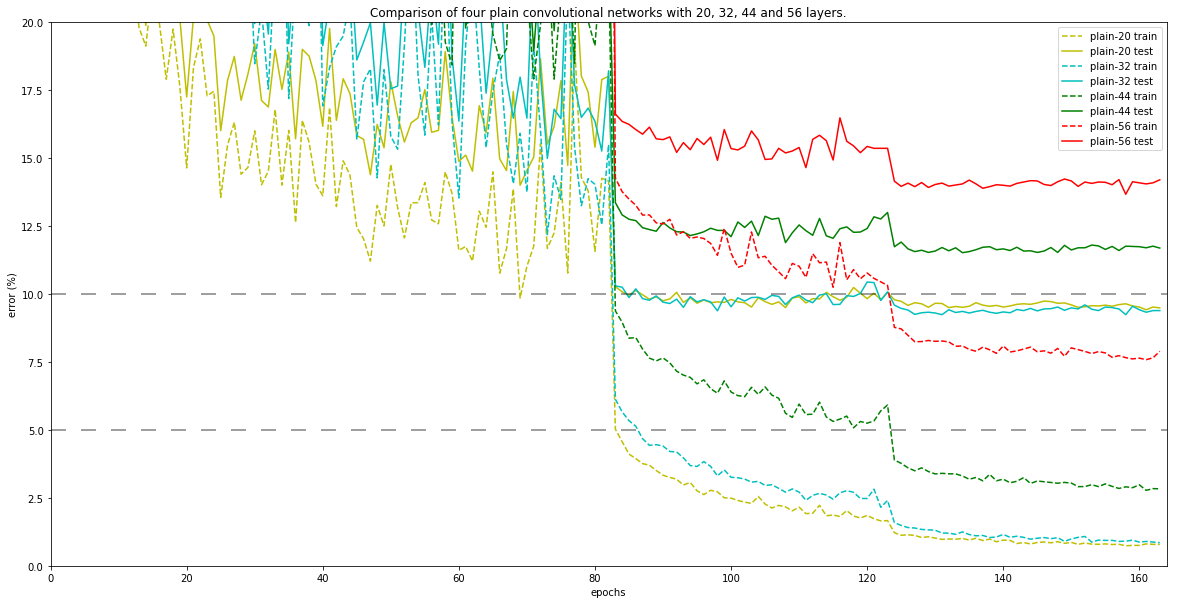

In [15]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [16]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
161,PlainNet20,0.0942
131,PlainNet32,0.0924
134,PlainNet44,0.1152
158,PlainNet56,0.1367


### Resnet

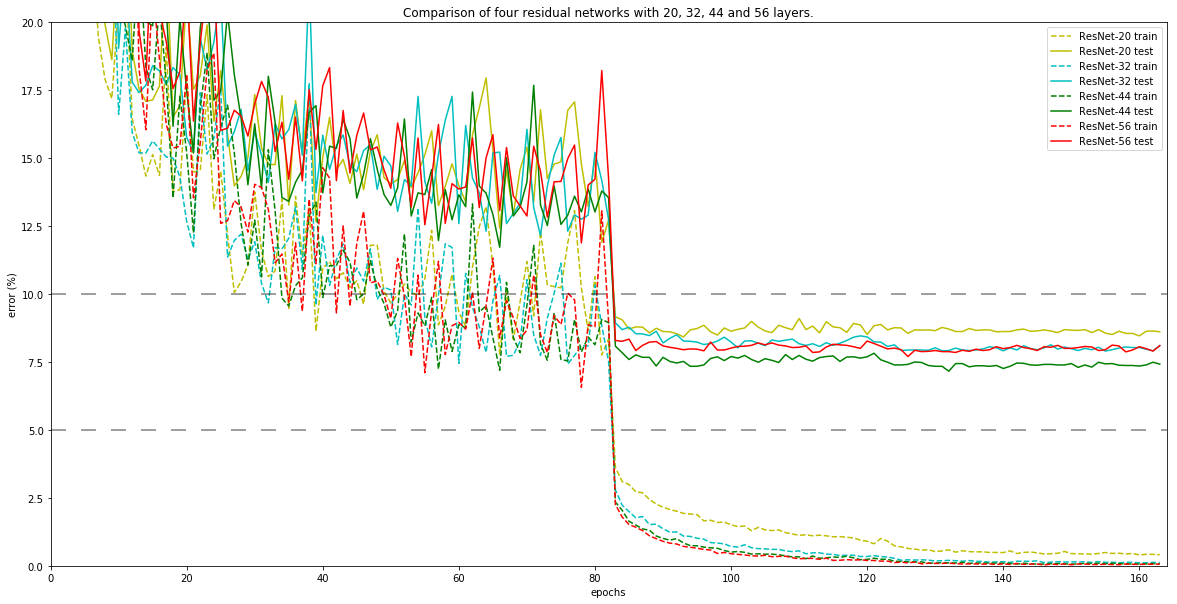

In [17]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [18]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])


,model,test_err
93,ResNet20,0.0842
155,ResNet32,0.0790
132,ResNet44,0.0716
126,ResNet56,0.0770


## Side-by-side plot

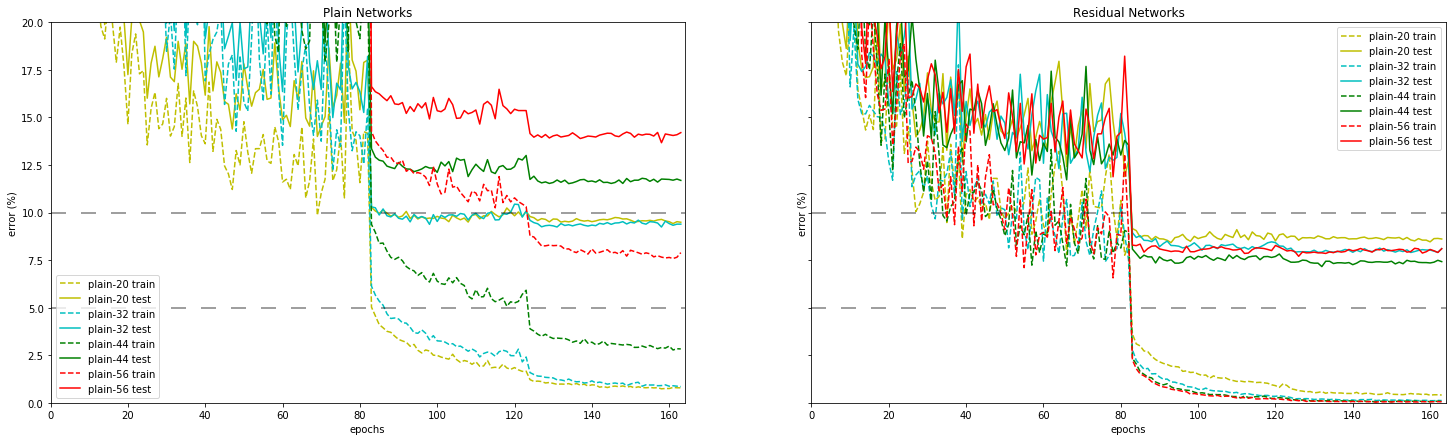

In [19]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')